In [1]:
from dataclasses import dataclass
from typing import Dict, Iterator, Mapping, Tuple
from rl.distribution import Categorical, Constant
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FinitePolicy, FiniteDeterministicPolicy

import itertools as it
import matplotlib.pyplot as plt
import numpy as np


#### Defining the Froggie-Escape Problem as an MDP:

* State Space:  $\mathcal{S} = \{0, 1, 2, \dots, n\}$, where both $0$, and $n$ are terminal states.

* Action Space: $\mathcal{A} = \{A, B\}$

* State-Transition Functions: 

$$
\mathcal{P}(s, A, s') = \begin{cases} \frac{n - s}{n} & s' = s+1 \\
                                      \frac{s}{n} & s' = s - 1 \\
                                      0 & \text{otherwise} \\ \end{cases}
$$

$$
\mathcal{P}(s, B, s') = \begin{cases} \frac{1}{n} & s' \neq s \\
                                      0 & \text{otherwise} \\ \end{cases}
$$

* State-Reward Functions:  If we want the value function to report the probability of the frog reaching state $n$ before state $0$, we will interpret $r_{t+1} = \chi(s_{t + 1} = n \wedge s_t \neq n )$.  Therefore, if $\gamma = 1.0$, 

$$
V(s) = \mathbb{E}[G_t \big| s_t = s] = \mathbb{P}[s_T = n \text{ for some $T > t$ } | s_t = s]
$$

#### Modeling the Froggie-Escape Problem:

In [2]:
@dataclass
class Froggie_State(int):
    lilypad_idx: int

    def __hash__(self):
        return super().__hash__()


@dataclass
class Froggie_Croak(str):
    croak: str

    def __hash__(self):
        return super().__hash__()


@dataclass
class Froggie_StateActionTransition:

    num_lilypads: int
    reward_method: str

    @property
    def get_stateaction_map(
        self,
    ) -> Mapping[
        Froggie_State, Mapping[Froggie_Croak, Categorical[Tuple[Froggie_State, float]]]
    ]:
        self.stateaction_map = {}
        for init_pad in np.arange(1, self.num_lilypads):
            for croak in {"A", "B"}:
                self.add_stateaction(state=Froggie_State(init_pad), croak=croak)
        return self.stateaction_map

    def add_stateaction(self, state: Froggie_State, croak: str) -> None:
        if state in self.stateaction_map.keys():

            self.stateaction_map[state].update(
                {croak: self.prob(action=croak, state=state)}
            )
        else:
            self.stateaction_map[state] = {croak: self.prob(action=croak, state=state)}

    def reward(self, state: Froggie_State, next_state: Froggie_State):
        if self.reward_method == "linear":
            return next_state.lilypad_idx
        elif self.reward_method == "comparative_linear":
            return next_state.lilypad_idx - state.lilypad_idx
        elif self.reward_method == "escape":
            return next_state.lilypad_idx == self.num_lilypads
        else:
            raise NotImplementedError()

    def prob(
        self,
        action: str,
        state: Froggie_State,
    ) -> Categorical[Tuple[Froggie_State, float]]:
        dist = {}
        if action == "A":
            down_state = Froggie_State(state.lilypad_idx - 1)
            dist[(down_state, self.reward(state, down_state))] = (
                state.lilypad_idx / self.num_lilypads
            )

            up_state = Froggie_State(state.lilypad_idx + 1)
            dist[(up_state, self.reward(state, up_state))] = (
                self.num_lilypads - state.lilypad_idx
            ) / self.num_lilypads
        elif action == "B":
            for pad_idx in range(0, self.num_lilypads + 1):
                if pad_idx == state.lilypad_idx:
                    continue
                else:
                    next_state = Froggie_State(pad_idx)
                    dist[(next_state, self.reward(state, next_state))] = (
                        1 / self.num_lilypads
                    )

        else:
            raise NotImplementedError()
        return Categorical(dist)


#### Create all Possible Finite Policies

In [3]:
def get_all_policy_maps(f: Froggie_StateActionTransition) -> Iterator[FinitePolicy]:
    def croak_policy_from_subset(A_subset: Tuple) -> FiniteDeterministicPolicy:
        policy_map: Dict[Froggie_State, Froggie_Croak] = {}
        for init_pad in np.arange(1, f.num_lilypads):
            if init_pad in A_subset:
                policy_map[Froggie_State(init_pad)] = Froggie_Croak("A")
            else:
                policy_map[Froggie_State(init_pad)] = Froggie_Croak("B")
        return FiniteDeterministicPolicy(policy_map)

    policy_iterator = it.chain([], [])
    for r in np.arange(1, f.num_lilypads):
        policy_iterator = it.chain(
            policy_iterator, it.combinations(iterable=np.arange(1, f.num_lilypads), r=r)
        )
    return map(croak_policy_from_subset, policy_iterator)


Text(0, 0.5, 'escape probability')

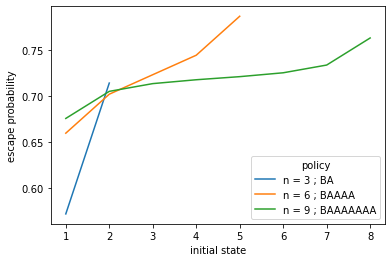

In [4]:
for n in [3, 6, 9]:

    f = Froggie_StateActionTransition(num_lilypads = n, reward_method = "escape")
    mdp = FiniteMarkovDecisionProcess(f.get_stateaction_map)

    V_s = np.zeros(shape = n-1)
    opt_policies = [None for x in range(n - 1)]

    for policy in get_all_policy_maps(f=f):
        mrp = mdp.apply_finite_policy(policy)
        V = mrp.get_value_function_vec(gamma = 1)
        for idx in np.arange(n-1):
            if V_s[idx] < V[idx]:
                V_s[idx] = V[idx]
                opt_policies[idx] = policy

    # verify that all policies are the same for each initial state
    for policy in opt_policies:
        assert(policy == opt_policies[0])
        
    plt.plot(np.arange(1, n), V_s, label=f"n = {n} ; " + "".join([x[-1] for x in str(opt_policies[0]).split('\n')[:-1]]))
    
plt.legend(title="policy")
plt.xlabel("initial state")
plt.ylabel("escape probability")
    

Amazingly, we see that the optimal policy is consistently given by "Croak A when at state 1; Croak B otherwise."!

#### Check with Monte Carlo Simulation

In [5]:
from rl.markov_process import NonTerminal

s_init = 0
policy = opt_policies[s_init]
mrp = mdp.apply_finite_policy(policy)
num_escapes = 0
num_sims = 1_000

for _ in range(num_sims):
    for hop in mrp.simulate_reward(Constant(NonTerminal(Froggie_State(1)))):
        if hop.reward:
            num_escapes += 1

print(f"check for n = {n} ; initial state {s_init}")
print(f"simulated probability : {num_escapes / num_sims}")
print(f"value function {mrp.get_value_function_vec(gamma = 1)[s_init]}")

check for n = 9 ; initial state 0
simulated probability : 0.675
value function 0.6756756756756744
